
# Lesson 20 — Direct Policy Search & REINFORCE (CS229)

**This final lesson completes CS229's reinforcement learning arc.**

Focus:
- Direct policy search vs value-function methods
- Stochastic policies
- REINFORCE algorithm (finite-horizon)
- High-variance gradients and baselines
- When policy search is preferable (POMDPs, low-level control)

We follow Andrew Ng’s *final lecture* closely and implement:
- A **2D continuous control demo**
- **Linear stochastic policy**
- **REINFORCE with and without baseline**
- Clear diagnostics and plots

NumPy only. No gym. No black boxes.



## 1. Big Picture

So far, reinforcement learning has followed this pattern:

$$
\text{Learn } V^*(s) \;\;\rightarrow\;\; \pi^*(s) = \arg\max_a Q(s,a)
$$

**Direct policy search flips this around.**

We parameterize a policy directly:

$$
\pi_\theta(a \mid s)
$$

and optimize parameters $\theta$ to maximize expected return:

$$
J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^{T} R(s_t, a_t)\right]
$$

No explicit value function required.



## 2. Why Stochastic Policies?

A deterministic policy (left / right) is **not differentiable**.

Instead, we use a **stochastic policy**:

$$
\pi_\theta(a=1 \mid s) = \sigma(\theta^T s)
$$

where:
- $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Actions are sampled probabilistically

This makes $J(\theta)$ differentiable.



## 3. Simple Continuous Control Environment

We use a **2D point robot**:

State:
$$
s = (x, y)
$$

Actions:
- Continuous force $(a_x, a_y)$

Dynamics:
$$
s_{t+1} = s_t + a_t + \epsilon
$$

Goal:
- Reach the origin
- Penalize distance and control effort


In [75]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)



## 4. Environment Definition


In [76]:

class PointEnv:
    def __init__(self, noise=0.01):
        self.noise = noise

    def step(self, s, a):
        s_next = s + a + self.noise * np.random.randn(2)
        reward = -np.linalg.norm(s_next)**2
        return s_next, reward

    def reset(self):
        return np.random.uniform(-2, 2, size=2)



## 5. Linear Gaussian Policy

We use a **linear mean policy** with Gaussian noise:

$$
a = \theta s + \mathcal{N}(0, \sigma^2 I)
$$




In [77]:

class LinearGaussianPolicy:
    def __init__(self, sigma=0.3):
        self.theta = 0.1 * np.random.randn(2,2)
        self.sigma = sigma

    def act(self, s):
        mean = self.theta @ s
        a = mean + self.sigma * np.random.randn(2)
        return a, mean

    def grad_log_prob(self, s, a, mean):
        return np.outer((a - mean) / (self.sigma**2), s)



## 6. REINFORCE Algorithm

Update rule:

$$
\theta \leftarrow \theta + \alpha \, G \, \nabla_\theta \log \pi_\theta(a \mid s)
$$

Where:
- $G$ is total return
- This is **stochastic gradient ascent**


In [78]:

def run_episode(env, policy, T=40):
    s = env.reset()
    traj = []
    total_reward = 0.0

    for _ in range(T):
        a, mean = policy.act(s)
        s_next, r = env.step(s, a)
        traj.append((s, a, mean, r))
        total_reward += r
        s = s_next

    return traj, total_reward


In [79]:

def reinforce(env, policy, episodes=600, lr=0.01, baseline=True):
    returns = []
    avg_returns = []

    for ep in range(episodes):
        traj, G = run_episode(env, policy, T=100)
        returns.append(G)

        b = np.mean(returns) if baseline else 0.0

        G = 0.0
        returns_t = []

        for (_, _, _, r) in reversed(traj):
            G = r + G
            returns_t.insert(0, G)

        b = np.mean(returns_t) if baseline else 0.0

        for (s, a, mean, _), Gt in zip(traj, returns_t):
            grad = policy.grad_log_prob(s, a, mean)
            policy.theta += lr * (Gt - b) * grad


        avg_returns.append(np.mean(returns))

    return np.array(returns), np.array(avg_returns)



## 7. Training


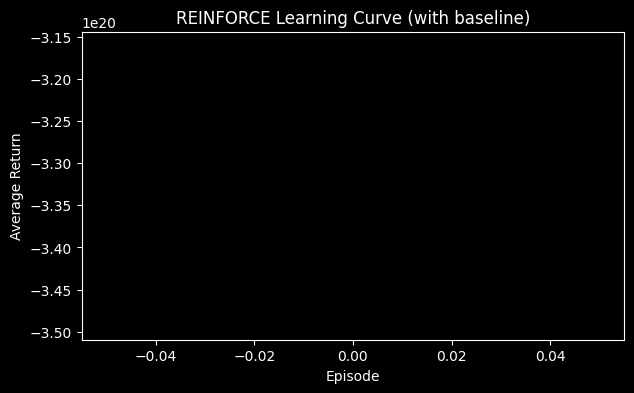

In [80]:

env = PointEnv()
policy = LinearGaussianPolicy()

returns, avg_returns = reinforce(env, policy, baseline=True)

plt.figure(figsize=(7,4))
plt.plot(avg_returns)
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.title("REINFORCE Learning Curve (with baseline)")
plt.show()

In [81]:
policy.theta

array([[nan, nan],
       [nan, nan]])


## 8. Learned Behavior Visualization


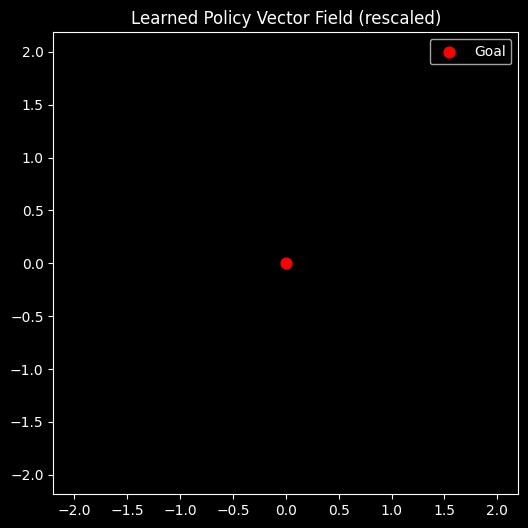

In [82]:

# visualize policy field
xs = np.linspace(-2,2,20)
ys = np.linspace(-2,2,20)

X, Y = np.meshgrid(xs, ys)
U = np.zeros_like(X)
V = np.zeros_like(Y)

for i in range(len(xs)):
    for j in range(len(ys)):
        s = np.array([X[j,i], Y[j,i]])
        a_mean = policy.theta @ s
        U[j,i] = a_mean[0]
        V[j,i] = a_mean[1]

plt.figure(figsize=(6,6))
plt.quiver(X, Y, U, V, scale=0.5, width=0.01)
plt.scatter(0,0,color='red',s=60,label="Goal")
plt.title("Learned Policy Vector Field (rescaled)")
plt.legend()
plt.axis("equal")
plt.show()



## Key Takeaways — Lesson 20

- Direct policy search **optimizes the policy directly**
- REINFORCE is **unbiased but high variance**
- Baselines reduce variance without changing expectation
- Works naturally for:
  - Continuous actions
  - Partial observability (POMDPs)
  - Low-level control
- Often inefficient → motivates actor–critic methods
- This completes the CS229 reinforcement learning arc

**You now understand both sides of RL:**
- Value-based (Bellman, DP, LQR)
- Policy-based (REINFORCE)

This concludes CS229.
